In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
NOTEBOOK_NAME = 'overlaps_withinSession_post_dhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../autorestore/%s/' % (notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [16]:
animals = ['dhpcg20']
trial = ['rewardt','CSmt','STIM1t','STIM2t','STIM3t','STIM4t']
feature = ['','_tr', '_us','_licks']
direction = ['','_up', '_dn']
for f in feature:
    for d in direction:
        for t in trial:
            try:
                what = np.concatenate([ut.load_variable('cells_%s%s%s'%(t,d,f),
                                       folder='../%s/post/notebooks/autorestore/tuning_stability_values_JSB/'%ani)
                                       for ani in animals])
                exec('cells_%s%s%s = what'%(t,d,f))
            except:
                print'failed', ani, 'cells_%s%s%s'%(t,d,f)

#                 exec('cells_%s%s_%s = ut.load_variable(\'cells_%s%s_%s\', folder=\'./autorestore/tuning_stability_values/\')'%(c,a,b,c, a, b))
##        exec('cells_%s%s_%s = what'%(c, a, b))
#    except IOError:
#        print("Skip", a, b, c)

failed dhpcg20 cells_CSmt_licks
failed dhpcg20 cells_STIM1t_licks
failed dhpcg20 cells_STIM2t_licks
failed dhpcg20 cells_STIM3t_licks
failed dhpcg20 cells_STIM4t_licks
failed dhpcg20 cells_CSmt_up_licks
failed dhpcg20 cells_STIM1t_up_licks
failed dhpcg20 cells_STIM2t_up_licks
failed dhpcg20 cells_STIM3t_up_licks
failed dhpcg20 cells_STIM4t_up_licks
failed dhpcg20 cells_CSmt_dn_licks
failed dhpcg20 cells_STIM1t_dn_licks
failed dhpcg20 cells_STIM2t_dn_licks
failed dhpcg20 cells_STIM3t_dn_licks
failed dhpcg20 cells_STIM4t_dn_licks


In [17]:
print len(cells_rewardt)
print len(cells_CSmt_up_tr)

211
211


In [18]:
N = len(cells_rewardt) #just a placeholder for below
n_loops = 10000

def calc_shuffle_overlap(pop1, pop2, n_loops=n_loops, N=N):
     return [(np.random.choice([0, 1], size=N, p=(1-pop1.mean(), pop1.mean()))*
                  np.random.choice([0, 1], size=N, p=(1-pop2.mean(), pop2.mean()))).mean() for r in range(n_loops)]



In [19]:
def sigtest(values, x):
    pval = [1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
    print 'p-value = ',
    print pval
    return [None, 1 - sstats.norm(np.mean(values), np.std(values)).cdf(x)]
def plot_hist(ax, vals, colors=['0.7', 'k'], bins=np.linspace(0, 0.3, 20), ids=[0, 1]):
    # ax.hist(vals2_all[0], bins=10, histtype='step', color='0.7')
    y, x = np.histogram(vals[ids[0]], bins=bins, normed=True)
    ax.step(x[:-1], y*np.diff(x)[0], color=colors[0], lw=1, where='post')
    ax.vlines(vals[ids[1]], 0, 0.4, color=colors[1], lw=1, zorder=19)
    y = np.diff(ax.axis()[-2:])*0.95 + ax.axis()[-2]
    pt.add_significance(ax, vals[ids[0]], vals[ids[1]], vals[ids[1]], vals[ids[1]], 0.5, sig_func=sigtest)
    pt.nicer_plot(ax)

In [20]:
def plot_it(pop1, pop2, untuned, est, labels=['Pre', 'Post', 'Pre+Post', 'Untuned'], title="Sucrose",
            colors=[(1, 0., 0.2), (1, 0.5, 0.2), (1, 0.8, 0.2), (0.8, 0.8, 0.8)],
            hist_colors=[(1, 0.7, 0.7), 'r']):
    fig, axs = pl.subplots(1, 2, figsize=(3, 1))

    ax = axs[0]
    plot_hist(ax, [est, (pop1*pop2).mean()], bins=np.linspace(0, 0.3, 17),
            colors=hist_colors)

    ax.set_xlabel('Co-tuned Cells Ratio')
    ax.set_ylabel('PDF')

    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 0.5)

    ax = axs[1]
    
    t = map(sum, [pop1*~pop2, pop2*~pop1, pop1*pop2, untuned])
    total = np.sum(t)
    _, txts, _ = ax.pie(t, colors=colors, explode=[0.05]*len(t),
                        autopct=lambda x: "%.1f%%"%(x),
                        labels=labels,
                        textprops={'fontsize':3})
    for tt in txts:
        tt.set_fontsize(5)
    ax.text(1, -1.3, 'n = %d'%total, fontsize=3)

    ax.set_aspect('equal')
    fig.suptitle(title)
    
    return fig, axs,

In [21]:
#set colors for figures
r1='lightskyblue'
r2='lightblue'
r12='royalblue'
s1='lightcoral'
s2='r'
s12='crimson'
c1='burlywood'
c2='peru'
c12='sienna'
f1='palegoldenrod'
f2='khaki'
f12='goldenrod'
b1='lightgreen'
b2='greenyellow'
b12='olivedrab'
g='lightgrey'

In [22]:
#initialize dictionary for chance vs observed overlap comparison
#entries will be mean chance overlap, observed overlap, observed-chance, (observed-chance)/chance,
    #z-score:(observed-chance)/STDev chance
diff_from_chance = {}

p-value =  [0.62385376457995423]
p-value =  [0.62385376457995423]


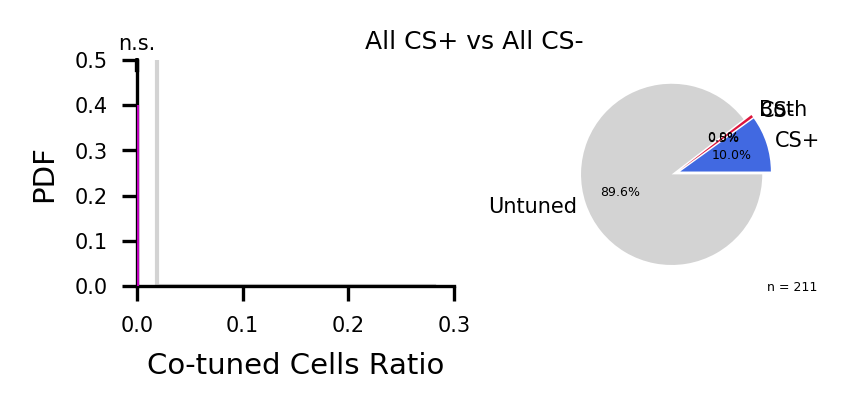

In [23]:
comparison = 'rewardt_vs_CSmt'
#try:
pop1 = cells_rewardt
pop2 = cells_CSmt
unt = ~(cells_rewardt + cells_CSmt)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r12,s12,'m',g], hist_colors=[g,'m'],
                  title='All CS+ vs All CS-', labels=['CS+', 'CS-', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
#print pval
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.1262444659476244]
p-value =  [0.1262444659476244]


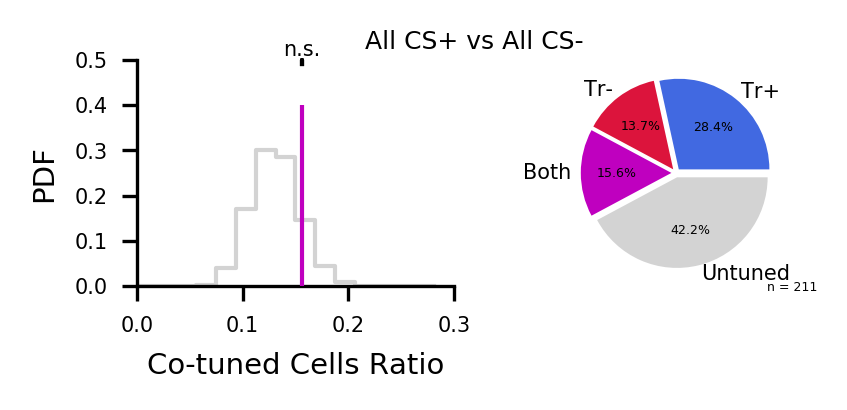

In [24]:
comparison = 'rewardt_tr_vs_CSmt_tr'
#try:
pop1 = cells_rewardt_tr
pop2 = cells_CSmt_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r12,s12,'m',g], hist_colors=[g,'m'],
                  title='All CS+ vs All CS-', labels=['Tr+', 'Tr-', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.569437811926231]
p-value =  [0.569437811926231]


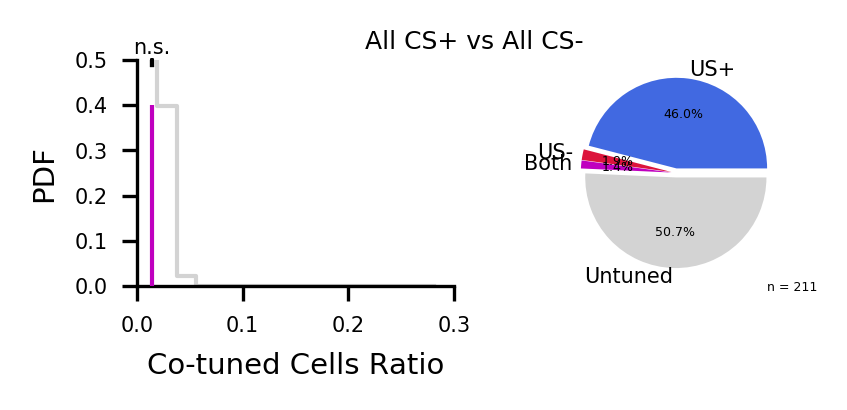

In [25]:
comparison = 'rewardt_us_vs_CSmt_us'
#try:
pop1 = cells_rewardt_us
pop2 = cells_CSmt_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r12,s12,'m',g], hist_colors=[g,'m'],
                  title='All CS+ vs All CS-', labels=['US+', 'US-', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.62656890683808741]
p-value =  [0.62656890683808741]


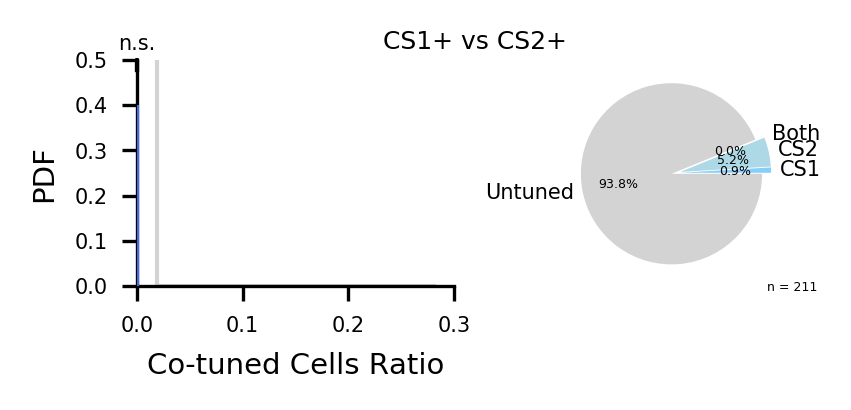

In [26]:
comparison = 'CS1_vs_CS2'
#try:
pop1 = cells_STIM1t
pop2 = cells_STIM2t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,r2,r12,g], hist_colors=[g,r12],
                  title='CS1+ vs CS2+', labels=['CS1', 'CS2', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.010511159955481353]
p-value =  [0.010511159955481353]


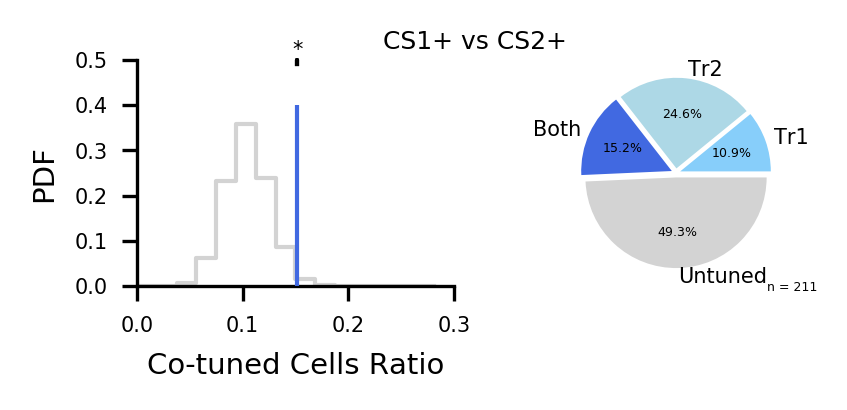

In [27]:
comparison = 'CS1_tr_vs_CS2_tr'
#try:
pop1 = cells_STIM1t_tr
pop2 = cells_STIM2t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,r2,r12,g], hist_colors=[g,r12],
                  title='CS1+ vs CS2+', labels=['Tr1', 'Tr2', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [4.7090331839472199e-06]
p-value =  [4.7090331839472199e-06]


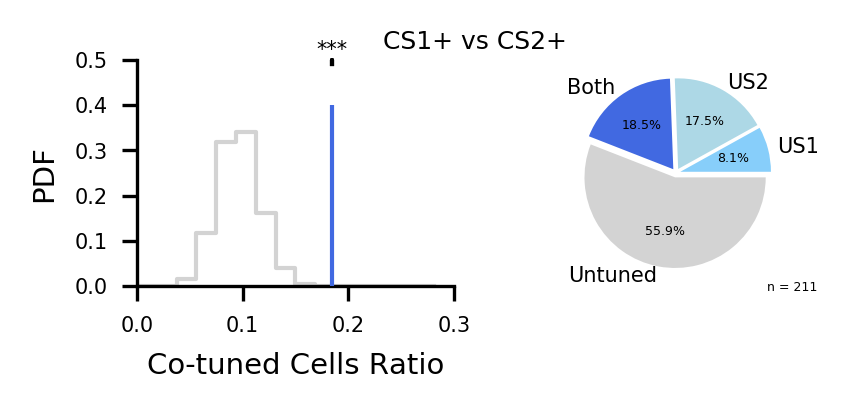

In [28]:
comparison = 'CS1_us_vs_CS2_us'
#try:
pop1 = cells_STIM1t_us
pop2 = cells_STIM2t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,r2,r12,g], hist_colors=[g,r12],
                  title='CS1+ vs CS2+', labels=['US1', 'US2', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.55563892500945677]
p-value =  [0.55563892500945677]


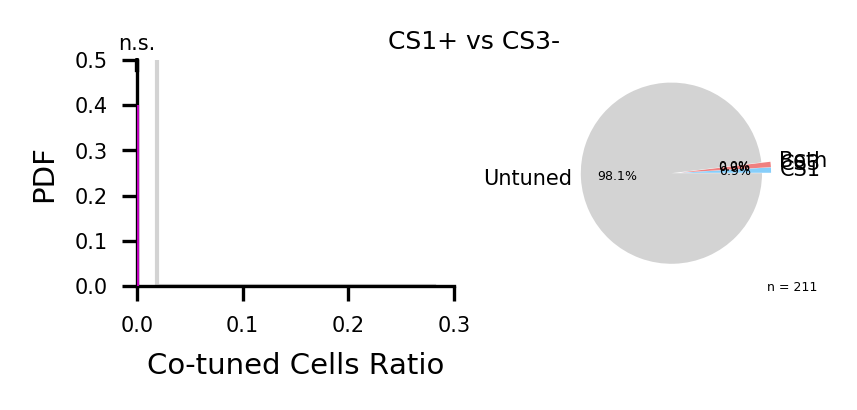

In [29]:
comparison = 'CS1_vs_CS3'
#try:
pop1 = cells_STIM1t
pop2 = cells_STIM3t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s1,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS3-', labels=['CS1', 'CS3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.33258601628532525]
p-value =  [0.33258601628532525]


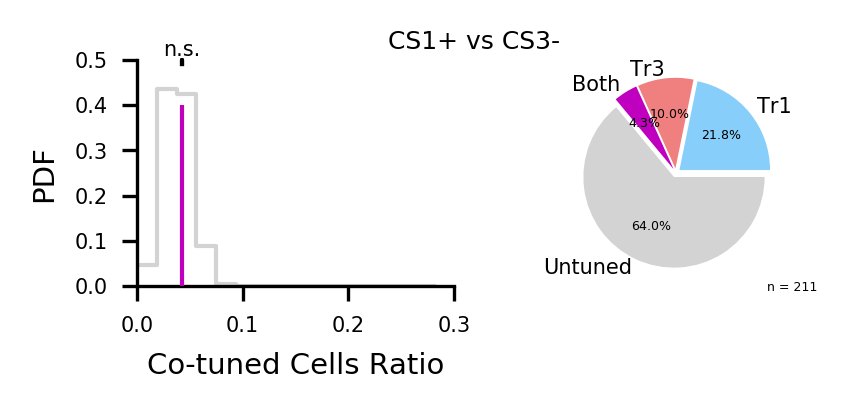

In [30]:
comparison = 'CS1_tr_vs_CS3_tr'
#try:
pop1 = cells_STIM1t_tr
pop2 = cells_STIM3t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s1,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS3-', labels=['Tr1', 'Tr3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.87579269853962849]
p-value =  [0.87579269853962849]


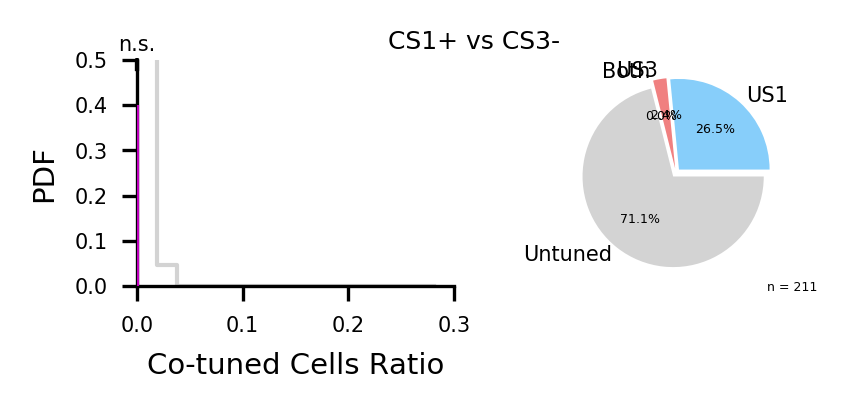

In [31]:
comparison = 'CS1_us_vs_CS3_us'
#try:
pop1 = cells_STIM1t_us
pop2 = cells_STIM3t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s1,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS3-', labels=['US1', 'US3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1732: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


p-value =  [nan]
p-value =  [nan]


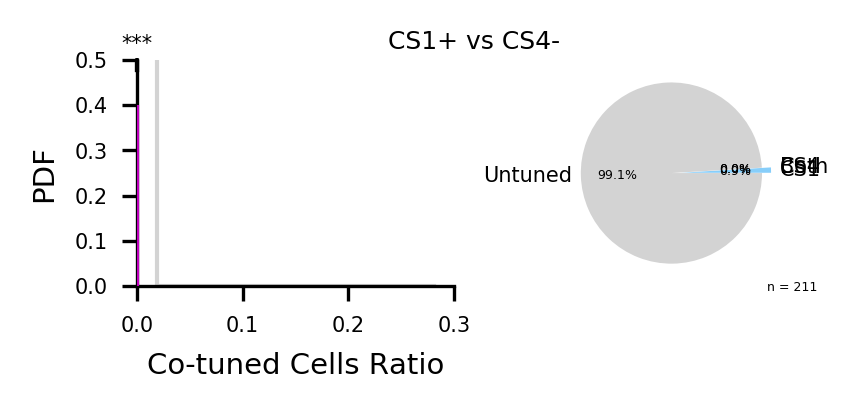

In [32]:
comparison = 'CS1_vs_CS4'
#try:
pop1 = cells_STIM1t
pop2 = cells_STIM4t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s2,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS4-', labels=['CS1', 'CS4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.26148750414565858]
p-value =  [0.26148750414565858]


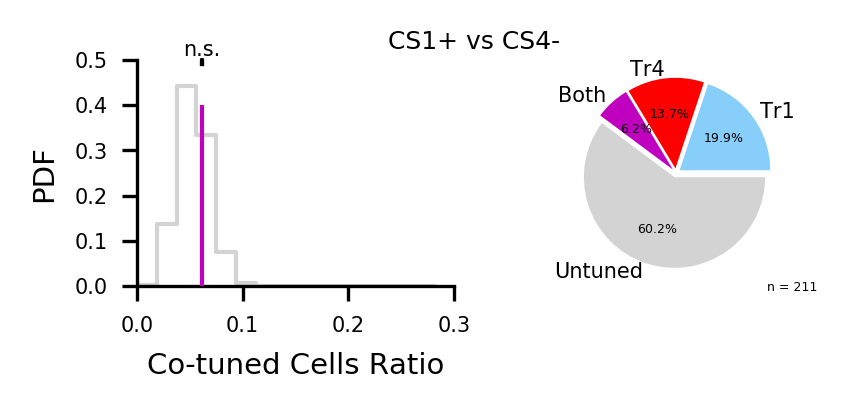

In [33]:
comparison = 'CS1_tr_vs_CS4_tr'
#try:
pop1 = cells_STIM1t_tr
pop2 = cells_STIM4t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s2,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS4-', labels=['Tr1', 'Tr4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.45434315279198856]
p-value =  [0.45434315279198856]


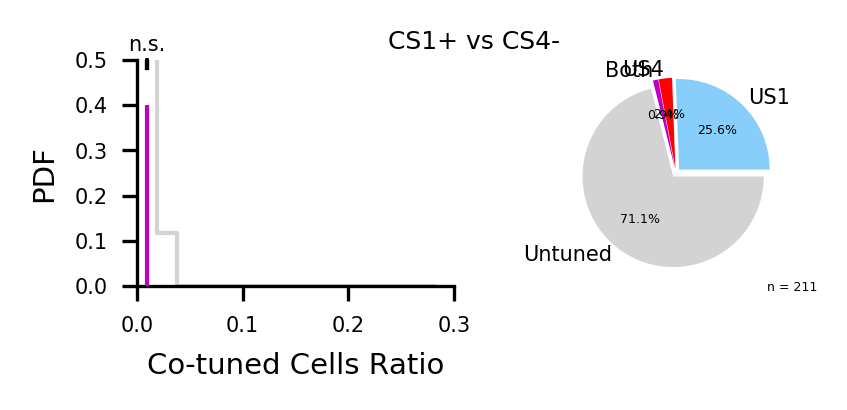

In [34]:
comparison = 'CS1_us_vs_CS4_us'
#try:
pop1 = cells_STIM1t_us
pop2 = cells_STIM4t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r1,s2,'m',g], hist_colors=[g,'m'],
                  title='CS1+ vs CS4-', labels=['US1', 'US4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.62591193560208636]
p-value =  [0.62591193560208636]


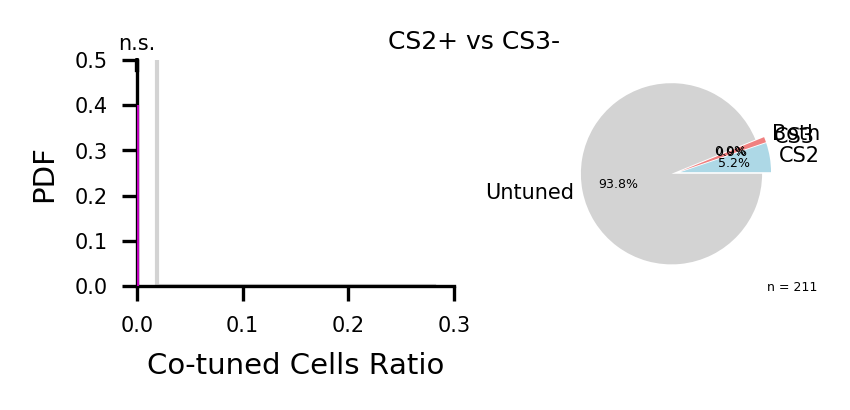

In [35]:
comparison = 'CS2_vs_CS3'
#try:
pop1 = cells_STIM2t
pop2 = cells_STIM3t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s1,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS3-', labels=['CS2', 'CS3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.18000225149771432]
p-value =  [0.18000225149771432]


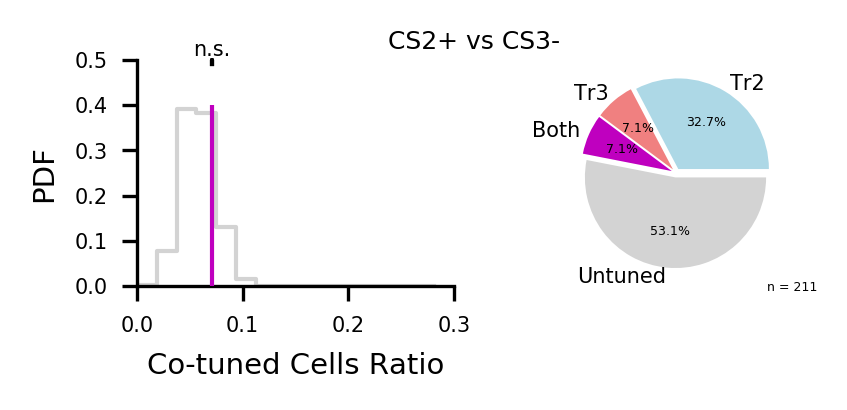

In [36]:
comparison = 'CS2_tr_vs_CS3_tr'
#try:
pop1 = cells_STIM2t_tr
pop2 = cells_STIM3t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s1,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS3-', labels=['Tr2', 'Tr3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.72165911055607967]
p-value =  [0.72165911055607967]


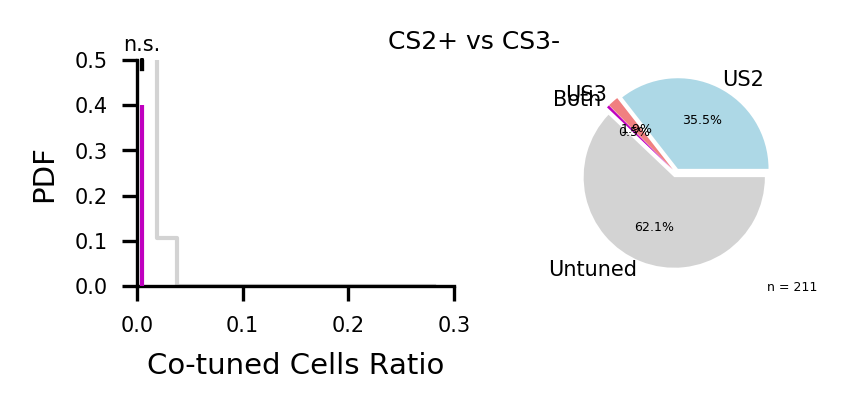

In [37]:
comparison = 'CS2_us_vs_CS3_us'
#try:
pop1 = cells_STIM2t_us
pop2 = cells_STIM3t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s1,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS3-', labels=['US2', 'US3', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [nan]
p-value =  [nan]


/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


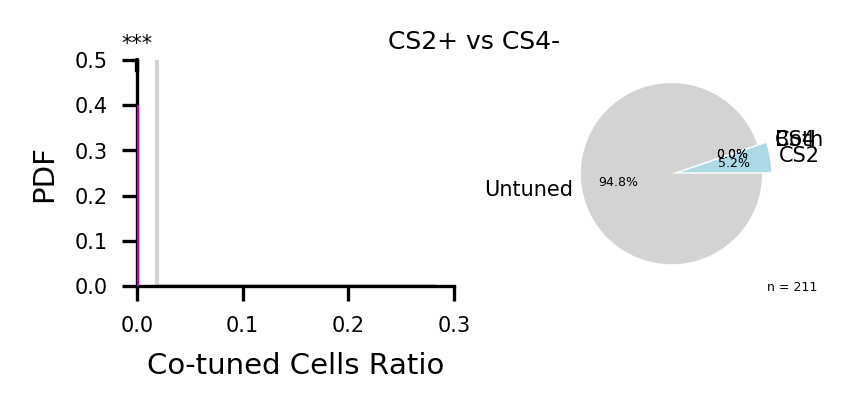

In [38]:
comparison = 'CS2_vs_CS4'
#try:
pop1 = cells_STIM2t
pop2 = cells_STIM4t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s2,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS4-', labels=['CS2', 'CS4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.28473661468595124]
p-value =  [0.28473661468595124]


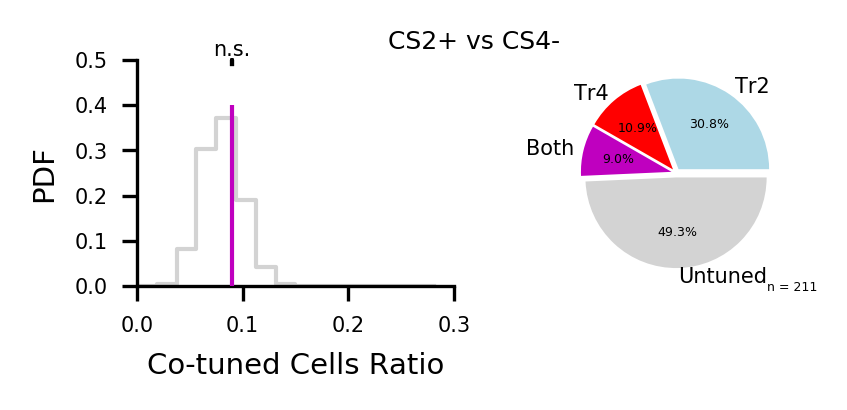

In [39]:
comparison = 'CS2_tr_vs_CS4_tr'
#try:
pop1 = cells_STIM2t_tr
pop2 = cells_STIM4t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s2,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS4-', labels=['Tr2', 'Tr4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.18024466961493935]
p-value =  [0.18024466961493935]


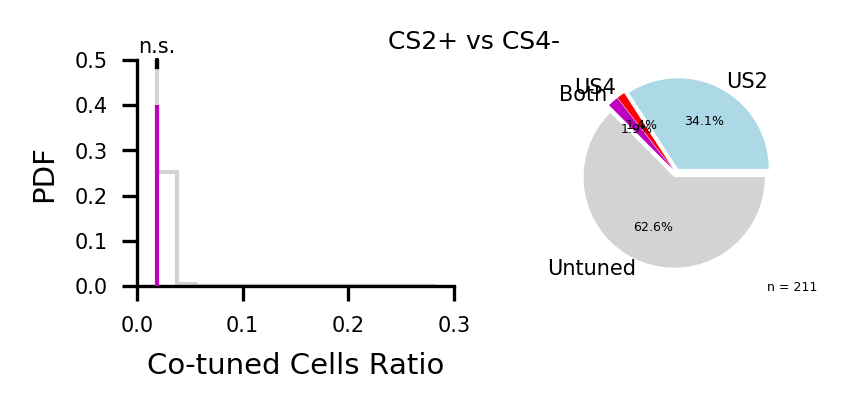

In [40]:
comparison = 'CS2_us_vs_CS4_us'
#try:
pop1 = cells_STIM2t_us
pop2 = cells_STIM4t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[r2,s2,'m',g], hist_colors=[g,'m'],
                  title='CS2+ vs CS4-', labels=['US2', 'US4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [nan]
p-value =  [nan]


/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


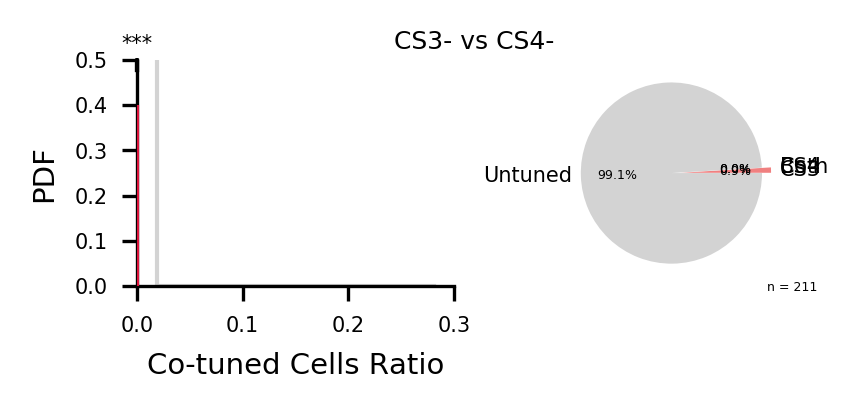

In [41]:
comparison = 'CS3_vs_CS4'
#try:
pop1 = cells_STIM3t
pop2 = cells_STIM4t
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[s1,s2,s12,g], hist_colors=[g,s12],
                  title='CS3- vs CS4-', labels=['CS3', 'CS4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.048418426937626879]
p-value =  [0.048418426937626879]


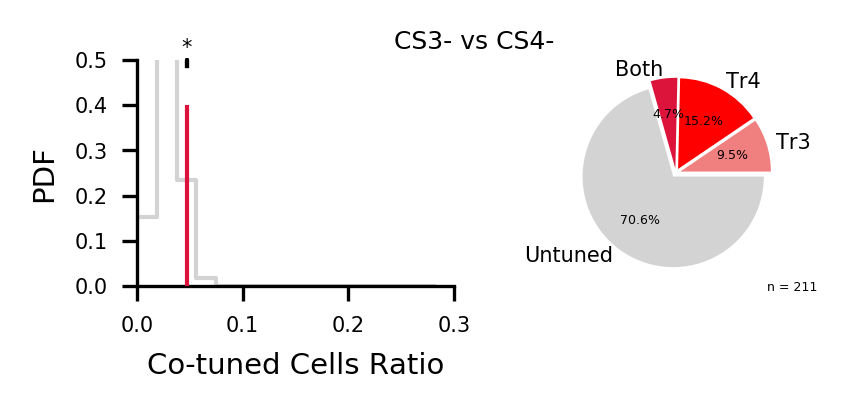

In [42]:
comparison = 'CS3_tr_vs_CS4_tr'
#try:
pop1 = cells_STIM3t_tr
pop2 = cells_STIM4t_tr
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[s1,s2,s12,g], hist_colors=[g,s12],
                  title='CS3- vs CS4-', labels=['Tr3', 'Tr4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

p-value =  [0.019853847744250586]
p-value =  [0.019853847744250586]


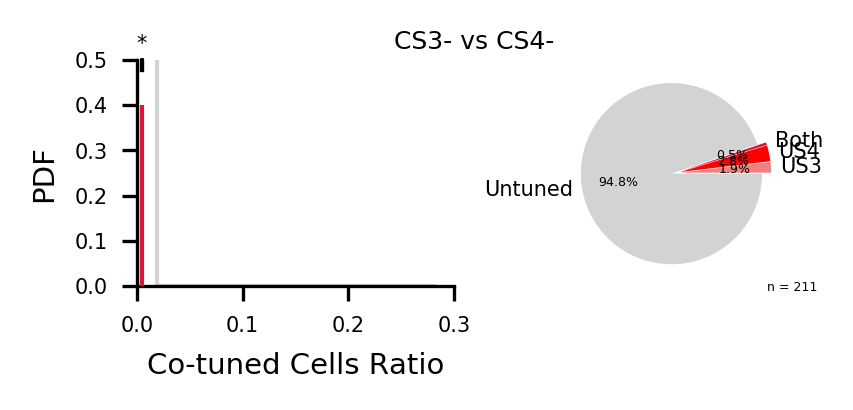

In [43]:
comparison = 'CS3_us_vs_CS4_us'
#try:
pop1 = cells_STIM3t_us
pop2 = cells_STIM4t_us
unt = ~(pop1 + pop2)
N = len(pop1)
est = calc_shuffle_overlap(pop1, pop2, n_loops=n_loops,N=N)

fig, axs = plot_it(pop1, pop2, unt, est,colors=[s1,s2,s12,g], hist_colors=[g,s12],
                  title='CS3- vs CS4-', labels=['US3', 'US4', 'Both', 'Untuned'])
diff_from_chance[comparison]=[np.mean(est),(pop1*pop2).mean(),((pop1*pop2).mean())-(np.mean(est)),
                          (((pop1*pop2).mean())-(np.mean(est)))/(np.mean(est)),(((pop1*pop2).mean())-(np.mean(est)))/(np.std(est))]
    #fig.savefig('../img/cotuned_%s.pdf' %(comparison))
#except:
#    print 'failed'

In [44]:
#diff_from_chance.iterkeys()

In [45]:
#sorted(diff_from_chance)

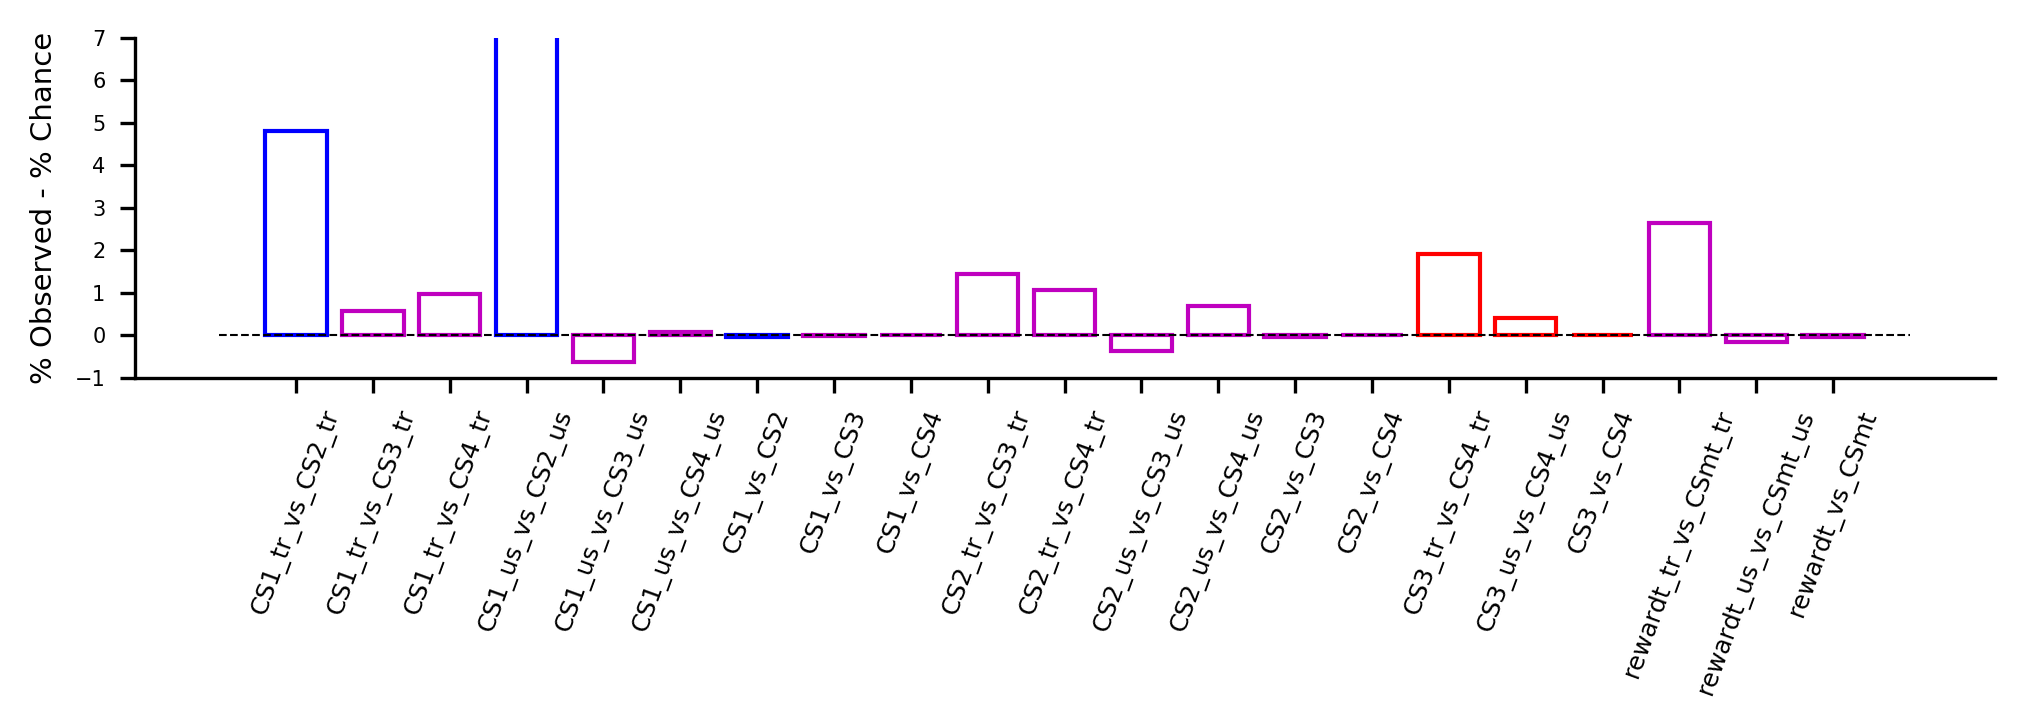

In [46]:
fig, ax = pl.subplots(1, 1, figsize=(8, 1.5))
values = [diff_from_chance[t][2]*100 for t in sorted (diff_from_chance)]
#values = [t[2] for t in diff_from_chance]
pt.plot_bars(values, ax=ax, colors = ['b','m','m','b','m','m','b','m','m','m','m','m','m','m','m','r','r','r','m','m','m'])
ax.set_xticks(range(len(diff_from_chance)))
ax.set_xticklabels(sorted (diff_from_chance), rotation=70, fontsize=6)
pt.nicer_plot(ax)
ax.set_ylim(-1,7)
ax.hlines(0, -1, len(diff_from_chance), 'k', 'dashed')
ax.set_ylabel('% Observed - % Chance')
fig.savefig('../img/vHPC_overlaps_ALL_comparisons_post_dhpc.jpg')

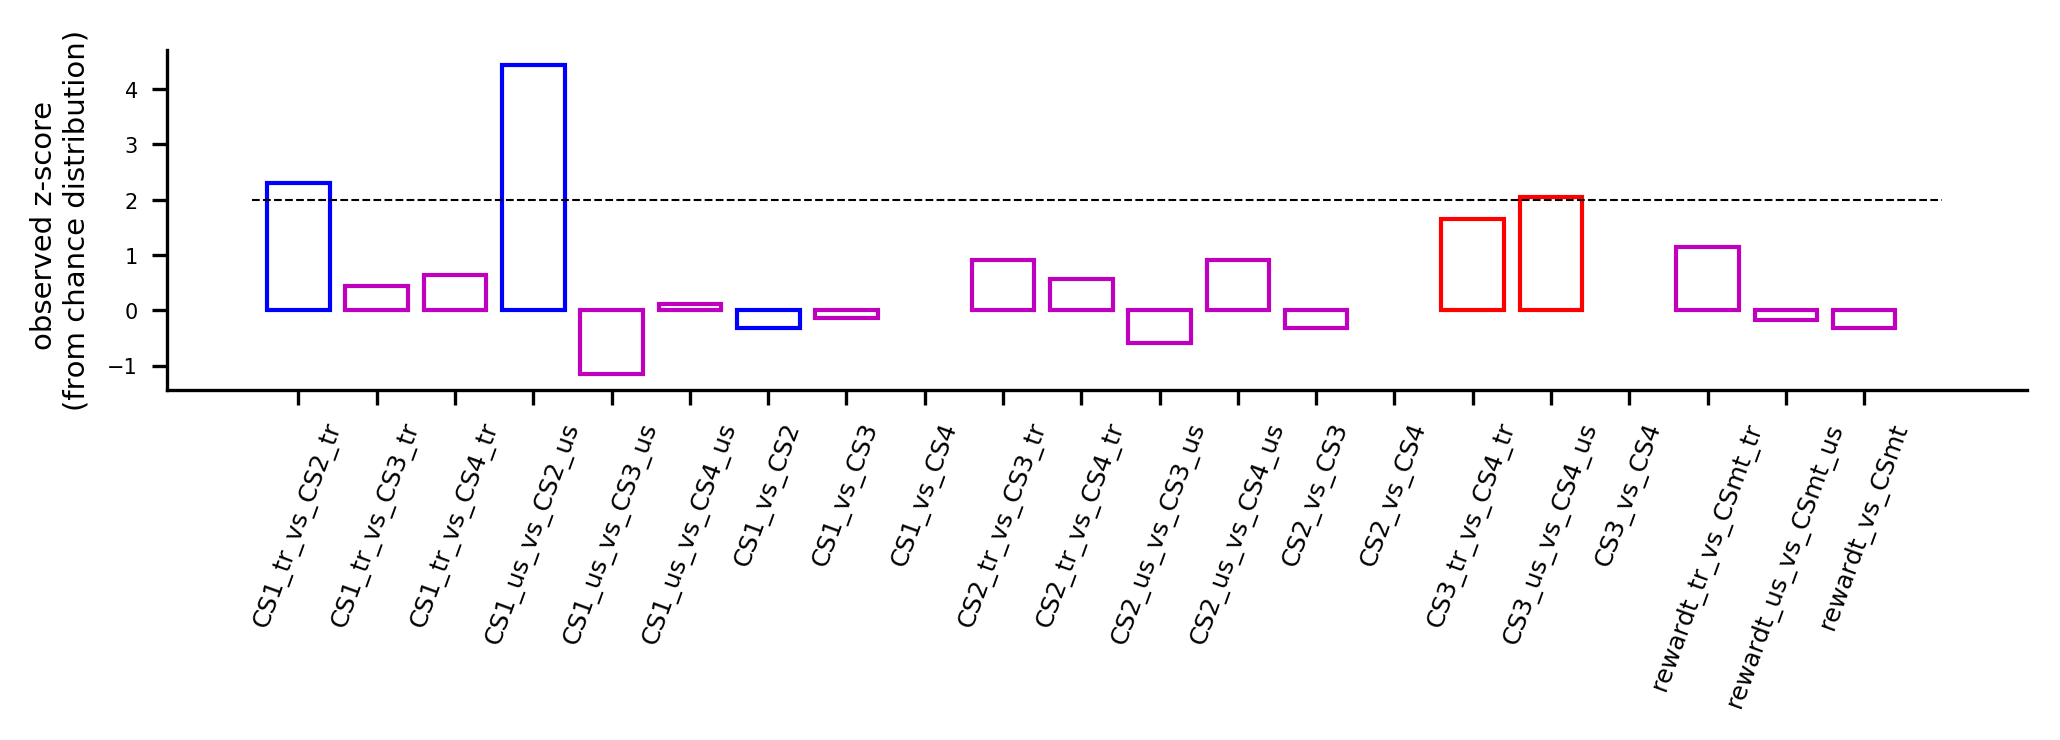

In [47]:
fig, ax = pl.subplots(1, 1, figsize=(8, 1.5))
values = [diff_from_chance[t][4] for t in sorted (diff_from_chance)]
pt.plot_bars(values, ax=ax, colors = ['b','m','m','b','m','m','b','m','m','m','m','m','m','m','m','r','r','r','m','m','m'])
ax.set_xticks(range(len(diff_from_chance)))
ax.set_xticklabels(sorted (diff_from_chance), rotation=70, fontsize=6)
ax.hlines(2, -0.6, len(diff_from_chance), 'k', 'dashed')
pt.nicer_plot(ax)
ax.set_ylabel('observed z-score \n(from chance distribution)')
fig.savefig('../img/vHPC_overlaps_ALL_comparisons_z-score_post_dhpc.jpg')

In [48]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
